Explanation of GAN Architecture

The architecture of GANs consists of two primary neural networks: the generator and the discriminator.

1. Generator:
   - The generator's role is to create new data, often by simulating samples that resemble those from a real dataset.
   - It takes random input data (often called noise) and generates samples that should become indistinguishable from real samples over time.

2. Discriminator:
   - The discriminator's task is to distinguish between real data from the training set and data generated by the generator.
   - It takes samples as input and assigns a probability that they come from the real dataset rather than being generated by the generator.
    
![alt text](image.png)   

Voici un autre schema :  
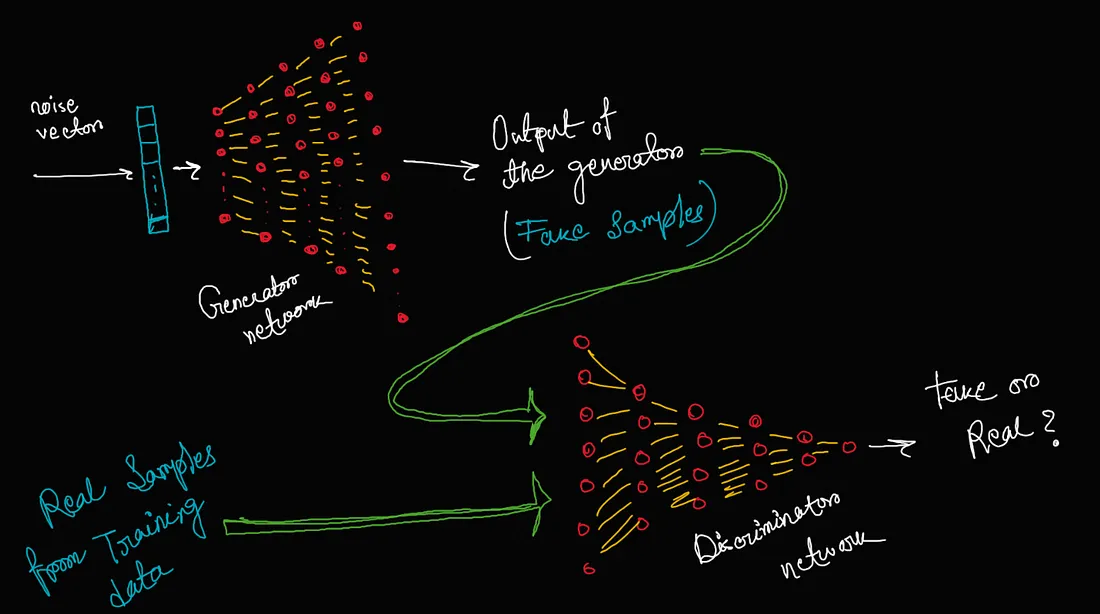  

From the diagram, two important concepts in GANs can be deduced:

1. **Generator loss**: The generator loss measures how well the generator is able to deceive the discriminator.
2. **Discriminator loss**: This measures the discriminator's ability to distinguish between real samples and samples generated by the generator.

Therefore, we can infer that the generator aims to minimize the discriminator loss, which reflects the discriminator's capability to differentiate between real and generated data.





In [3]:
import numpy as np
import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [4]:
file_path = 'irrigation_dataset.csv'
data = pd.read_csv(file_path)

In [5]:
# Creating a DataFrame for the data and changing the column names to their indices to facilitate manipulation
def _df(data) : 
    df = pd.DataFrame(data)
    for c in range (df.shape[1]) :
        mapping = {df.columns[c] : c}
        df = df.rename(columns=mapping)
    return df 

In [6]:
# Separating the target variable from the other data 
X = (data.drop(columns=['Irrigation(Y/N)'])).values
y = (data['Irrigation(Y/N)']).values

In [7]:
# Handling missing data if they exist
X = KNNImputer().fit_transform(X)
# Normalizing the data to have the same scale
data = _df(StandardScaler().fit_transform(np.column_stack((X,y))))

Initially, we will train both models:
- The generator learns to generate plausible data. The generated instances become negative training examples for the discriminator.
- The discriminator learns to distinguish between fake and real data. The discriminator penalizes the generator for producing undetectable outputs.

Next, we define a model that combines the two, which we'll call GAN, where only the generator is trained.

During the training of the generator, we want the discriminator to remain constant (non-trainable) so that the generator learns to generate data that fools the current discriminator. If the discriminator were trained simultaneously with the generator, it could adjust quickly and render the generator incapable of fooling it.

- In a GAN architecture, we always start by training the discriminator first because initially, the generator produces low-quality data. Starting with training the generator could lead it to produce samples that are too easy for the discriminator to distinguish. This would make it difficult for the generator to learn, as it wouldn't receive a strong signal to adjust its weights.

Here is an example of a generator architecture:
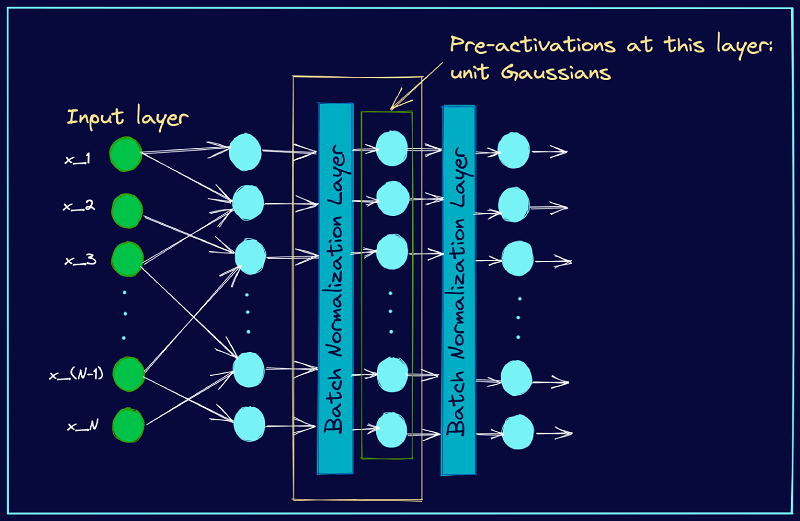  

- The BatchNormalization layer: serves to normalize and stabilize activations from the previous layer, enabling higher learning rates and acting as a form of regularization.
  In our case, the first layer has 128 neurons, and the second has 256 neurons.
- The "output" layer has 150 neurons (the number of instances in the dataset).

In [73]:
class Gan():
    def __init__(self, data):
        self.data = data
        self.n_epochs = 350 # number of passes

    def _noise(self):
        noise = np.random.normal(0, 1, (self.data.shape[0], 100))
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        # fist dense layerr 
        model.add(tf.keras.layers.Dense(128, input_dim=100, activation='relu'))
        # A batch normalization layer to normalize and stabilize activations from the previous layer
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(256, activation='relu')) # Rectified linear unit, non-linear f(x) = max(0,x)
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(self.data.shape[1], activation="linear")) # identity activation layer, used in output layers 
        return model

    def _discriminator(self): 
        model = tf.keras.Sequential(name="Discriminator_model") 
        model.add(tf.keras.layers.Dense(256, input_dim=self.data.shape[1], activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        # We add a dropout layer with a rate of 0.5 to prevent overfitting
        # randomly "turn off" a certain percentage of neurons during training
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #sigmoid for real or fake 
        # now to specify the loss function, optimizer and evaluation metrics we use this : 
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        model = tf.keras.Sequential(name="GAN_model")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    def train(self, generator, discriminator, gan):
        for epoch in range(self.n_epochs):
            generated_data = generator.predict(self._noise())
            
           # Applying a threshold to make the last variable boolean
            threshold = 0.5
            generated_data[:, -1] = generated_data[:, -1] > threshold
            
            labels_real = np.ones((self.data.shape[0], 1))
            labels_fake = np.zeros((self.data.shape[0], 1))

            # Train discriminator on real data
            d_loss_real = discriminator.train_on_batch(self.data, labels_real)
            # Train discriminator on generated data
            d_loss_fake = discriminator.train_on_batch(generated_data, labels_fake)

            # Calculate discriminator loss
            # d_loss est une mesure de perfomance du discriminateur 
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator to fool the discriminator
            noise = self._noise()
            # We set the label vector to 1 to make the discriminator believe it's real data
            # We instruct the generator to generate data that resembles the original real data
            labels_gan = np.ones((self.data.shape[0], 1))
            g_loss = gan.train_on_batch(noise, labels_gan)

            print('>%d, d=%.3f, g=%.3f' % (epoch + 1, d_loss[0], g_loss))
                                                                        
        return generator


Sometimes, it is advisable to add a Dropout layer to the discriminator to prevent overfitting.
  
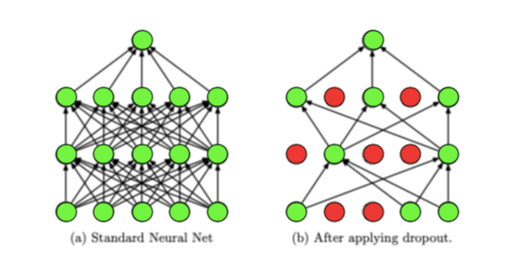  

Now, we test 

In [74]:
model = Gan(data=data)
generator = model._generator()
discriminator = model._discriminator()
gan_model = model._GAN(generator=generator,discriminator=discriminator)
trained_model = model.train(generator=generator, discriminator=discriminator, gan=gan_model)

5/5 [==============================] - 0s 0s/step
>1, d=1.035, g=0.788
5/5 [==============================] - 0s 0s/step
>2, d=0.995, g=0.788
5/5 [==============================] - 0s 0s/step
>3, d=0.967, g=0.755
5/5 [==============================] - 0s 2ms/step
>4, d=0.941, g=0.721
5/5 [==============================] - 0s 4ms/step
>5, d=0.941, g=0.681
5/5 [==============================] - 0s 0s/step
>6, d=0.932, g=0.701
5/5 [==============================] - 0s 1ms/step
>7, d=0.918, g=0.678
5/5 [==============================] - 0s 2ms/step
>8, d=0.972, g=0.683
5/5 [==============================] - 0s 0s/step
>9, d=0.949, g=0.668
5/5 [==============================] - 0s 2ms/step
>10, d=0.894, g=0.662
5/5 [==============================] - 0s 0s/step
>11, d=0.941, g=0.654
5/5 [==============================] - 0s 0s/step
>12, d=0.890, g=0.650
5/5 [==============================] - 0s 2ms/step
>13, d=0.893, g=0.635
5/5 [==============================] - 0s 2ms/step
>14, d=0.884, g=

In [75]:
# We generate the data
noise = np.random.normal(0, 1, (data.shape[0], 100))
new_data = _df(data=trained_model.predict(noise))

5/5 [==============================] - 0s 2ms/step


We need to make sure the last variable is boolean

In [76]:
# Convert the last column to boolean based on the threshold
threshold = 0
new_data.iloc[:, -1] = (new_data.iloc[:, -1] > threshold).astype(int)

# Convert the first column to 1 or 2
new_threshold = 2.0
new_data.iloc[:, 0] = np.where(new_data.iloc[:, 0] > new_threshold, 2, 1)

# Standarisation des nouvelles donnees 
scaler = StandardScaler()
new_data = pd.DataFrame(scaler.fit_transform(new_data), columns=new_data.columns)


In [19]:
new_data

,0,1,2,3,4,5,6
0,-0.707107,-1.709071,1.262663,-1.269904,2.052683,-1.414430,2.236068
1,-0.707107,-1.674427,0.410325,-0.722532,1.522731,-1.717522,-0.447214
2,-0.707107,-1.639784,-0.742837,0.372213,2.052683,-2.020614,-0.447214
3,-0.707107,-1.605141,-1.194075,1.466958,0.727802,0.101031,-0.447214
4,-0.707107,-1.570497,1.713901,-1.817276,0.727802,0.252577,2.236068
...,...,...,...,...,...,...,...
145,1.414214,1.408829,-1.389611,1.466958,-0.597080,-0.505154,-0.447214
146,1.414214,1.478115,0.234844,-0.722532,-0.597080,-0.505154,2.236068
147,1.414214,1.547402,-0.286586,0.372213,-0.332104,-0.353608,-0.447214
148,1.414214,1.616689,-0.823057,0.919586,-0.597080,-0.050515,-0.447214


The new dataset is the same size as the old one

In [81]:
new_data.count()

0    150
1    150
2    150
3    150
4    150
5    150
6    150
dtype: int64

We obtain a new dataset that is twice the size of the original one

In [86]:
data_augmented = np.concatenate([data,new_data])
df_augmented = pd.DataFrame(data_augmented)
df_augmented.count()

0    300
1    300
2    300
3    300
4    300
5    300
6    300
dtype: int64

We need the generated data to be similar to the real data. Therefore, in the following steps, we will compare between the two.

First, we will display the correlation matrices between the variables of the dataset, for both the real data and the generated synthetic data.

Text(0.5, 1.0, 'synthetic Data')

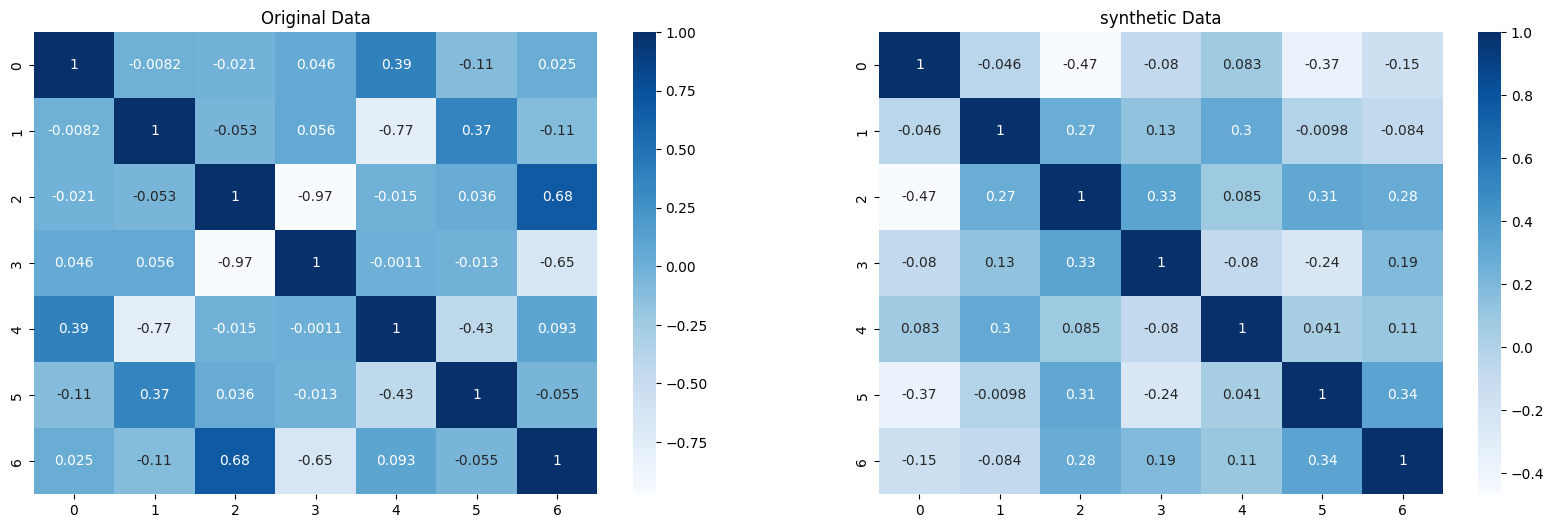

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(data.corr(), annot=True, ax=ax[0], cmap="Blues")
sns.heatmap(new_data.corr(), annot=True, ax=ax[1], cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

We observe a similarity between the generated data and the real data. We represent all individuals in a two-dimensional space using the scatter() function.

We notice that in both cases, the data points are vertically aligned.

Text(0.5, 1.0, 'synthetic Data')

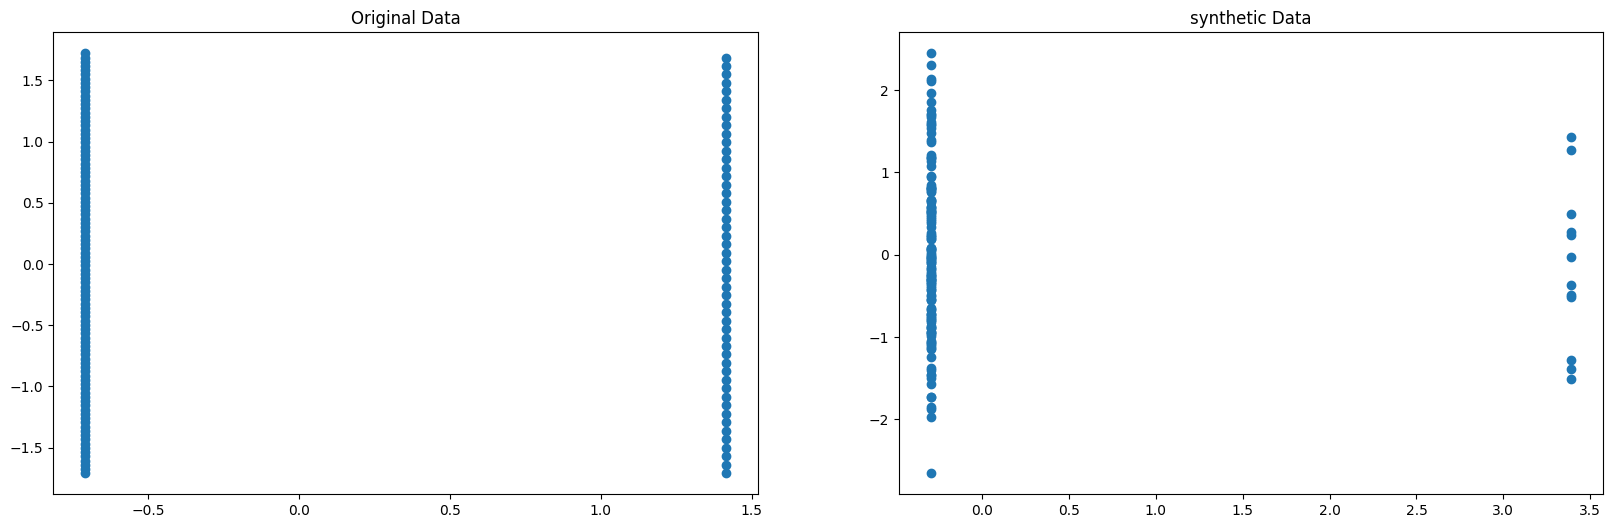

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(data.iloc[:, 0], data.iloc[:, 1])
ax[1].scatter(new_data.iloc[:, 0], new_data.iloc[:, 1])
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

To better compare between the two types of data, we create a histogram representing the distribution of a specific feature 'Humidity' in both types of data.

Once again, we notice a similarity between the two types of data.

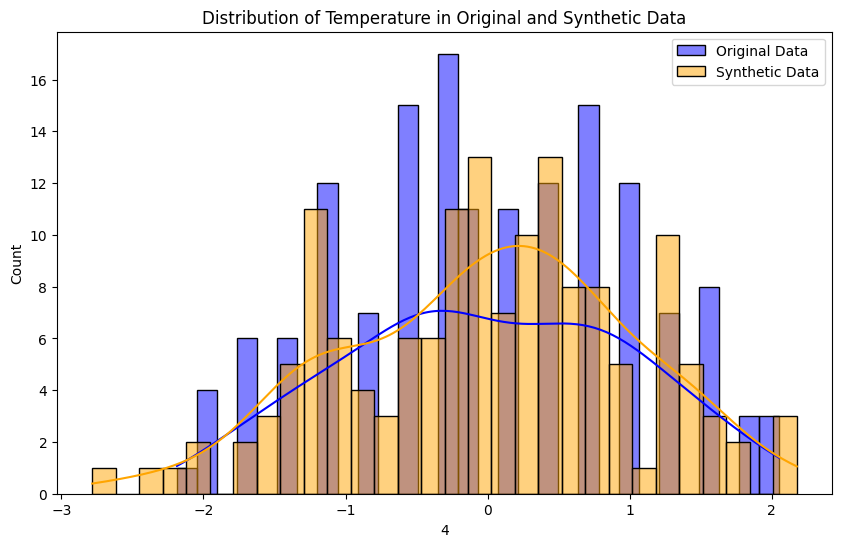

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

column_index = 4
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data.iloc[:, column_index], bins=30, kde=True, label="Original Data", color='blue', ax=ax)
sns.histplot(new_data.iloc[:, column_index], bins=30, kde=True, label="Synthetic Data", color='orange', ax=ax)
ax.set_title("Distribution of Temperature in Original and Synthetic Data")
ax.legend()
plt.show()


Now, we need to concatenate the two types of samples into a single dataset called `new_dataset` using the inverse function of StandardScaler().

In [ ]:
# Read the original data again
data = pd.read_csv(file_path)
scaler = StandardScaler()

# Fit the scaler on the original data and transform it
scaler.fit(data)
new_data_inverse = pd.DataFrame(scaler.inverse_transform(new_data), columns=data.columns)

# Replace negative values with a specific integer (e.g., -1)
new_data_inverse = new_data_inverse.mask(new_data_inverse < 0, -1)

# Make the last variable boolean
new_data_inverse['Irrigation(Y/N)'] = (new_data_inverse['Irrigation(Y/N)'] > threshold).astype(int)

# Convert the first column back to original values
new_data_inverse['CropType'] = np.where(new_data_inverse['CropType'] > new_threshold, 2, 1)

# Convert all values to integers
new_data_inverse = new_data_inverse.astype(int)

# Concatenate generated data and real data
data_combined = pd.concat([data, new_data_inverse], ignore_index=True)

# Save to a new CSV file
combined_file_path = 'new_dataset.csv'
data_combined.to_csv(combined_file_path, index=False)


- Conclusion:
    The application of a GAN model to generate synthetic data has yielded promising results in reproducing certain characteristics of our agricultural dataset. By comparing the distributions of original and synthetic data, we observed similarities in several features, suggesting that the GAN has successfully captured the underlying structure of these data.